## Logistic Regression by L2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import math 
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , StratifiedKFold,KFold

## Read the data

#### We use iris data for the logistic regression. For creating binary data, we set setosa Species to 0 and the others as 1.

In [2]:
iris_d = sm.datasets.get_rdataset('iris')
iris = iris_d.data
iris.rename(columns=lambda x: x.replace('.', ''), inplace=True)
iris.loc[iris.Species != 'setosa','Species']=1
iris.loc[iris.Species == 'setosa','Species']=0
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


#### We split train(70%) and test(30%) data.
- y_test and y_train are test and train targets.
- x_test and x_train are test and train features.

In [3]:
test = iris.sample(frac=0.3,random_state=4)
train_mask = pd.Series(True, index=iris.index)
train_mask[test.index] = False
train = iris[train_mask]

y_test = test.Species
y_train = train.Species

x_test = test.drop('Species', axis=1)
x_train = train.drop('Species', axis=1)

#### We need to standardize the dataset, then we subtract the mean of the feature column from each column and devide the result by the standard deviation of the column.

In [4]:
x_train_std = (x_train-np.mean(x_train))/np.std(x_train)
x_test_std = (x_test-np.mean(x_test))/np.std(x_test)

## Logistic Regression with l2 norm

- X in the function is features
- Y is the target (0 or 1)
- theta is the coefficients we want to estimate
- lrnn_rte is the information or learning rate of the gradient ascent (here 0.01)
- num_itr is the number of iteration for ending the gradient ascent optimization 
- C is the lambda parameter

In [5]:
def logistic_reg_l2(X,Y,lrn_rte,num_itr,C):
    X = np.hstack((np.ones((len(X), 1)), X))
    theta = np.zeros((X.shape[1], 1))

    # loop over number of iterations
    for itr in range(num_itr):

    # predict probability for each row in the dataset
        predictions = (1 / (1 + np.exp(-np.dot(X, theta))))
        
    # calculate the errors
        errors = (np.array([Y])).T - predictions

    # loop over each weight coefficient
        for i in range(len(theta)):
            
    # derivation of log-likelihood function + l2 regularization        
            drvt = np.dot((errors).T, X[:,i])
            if i!=0:
                drvt -= 2 * C * theta[i]
                
    # Gradient Ascent update          
            theta[i] += lrn_rte * drvt
        
    return theta

## Results

In [6]:
theta = logistic_reg_l2(x_train_std, y_train,1e-2,100,1)

#### For finding the accuracy we need to add ones column to the train and test feature data for intercept.

In [7]:
X_test  = np.hstack((np.ones((len(x_test_std), 1)), x_test_std))
X_train  = np.hstack((np.ones((len(x_train_std), 1)), x_train_std))

#### Probabilities (sigmoid) greater than 0.5 are taken as 1 and probabilities less than 0.5 are taken as 0

In [8]:
test_predictions  = ((1 / (1 + np.exp(-np.dot(X_test, theta)))).flatten()>0.5)
train_predictions = ((1 / (1 + np.exp(-np.dot(X_train, theta)))).flatten()>0.5)

#### Train Accuracy

In [9]:
prd_train = pd.DataFrame({'estimate':(train_predictions).astype('int64'), 'real':y_train,'count':np.ones((len(y_train)))})
prd_admt_train = pd.DataFrame(prd_train,columns=['estimate','real','count'])
out_counts_train = prd_admt_train.groupby(['estimate', 'real'])['count'].count()
# out_counts_test.unstack()
(out_counts_train[0][0]+out_counts_train[1][1])/sum(out_counts_train)

1.0

#### Test Accuracy

In [10]:
prd_test = pd.DataFrame({'estimate':(test_predictions).astype('int64'), 'real':y_test,'count':np.ones((len(y_test)))})
prd_admt_test = pd.DataFrame(prd_test,columns=['estimate','real','count'])
out_counts_test = prd_admt_test.groupby(['estimate', 'real'])['count'].count()
(out_counts_test[0][0]+out_counts_test[1][1])/sum(out_counts_test)

0.9777777777777777

## Read the data

#### We set y value for all species rather than Setosa equal 1

In [11]:
iris = datasets.load_iris()
X = iris.data
y = iris.target 
y[y == 2]=1

In [12]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
sc = StandardScaler()
X_test_std = sc.fit_transform(X_test)

## Logistic Regression fit by l2 and the results (accuracy, precision, recall, F1_score)
#### We use K-fold cross validation with number of splits equal 5
#### We also standardize train and tests 

- C : the inverse of the lambda
- n_splits : number of splits for K-Fold cross validation
- ind : list of test and train index splitted by K-Fold
- df2 : result dataframe containing the C, fold number, train accuracy, test accuracy, recall, precision, F1_score
- X_train_std: standardized train features
- X_test_std: standardized test features
- X_validation: standardized validation features
- y_train: train targets (0,1)
- y_test: test targets (0,1)
- y_validation: validation targets (0,1)
- y_train_predict: train prediction
- y_validation_predict: validation prediction 

In [13]:
# defining "C" values
C = np.linspace(0.0001,0.05,50)

# number of splits for K-Fold cross validation
n_splits= 5

# Defining a K-Fold cross validation
skf = KFold(n_splits=n_splits,random_state=4,shuffle=True )

# Train and validation data index
ind = list(skf.split(X, y))

# Empty DataFrame for results
df2 = pd.DataFrame()

# loop over "C" and different folds
for i in C:
    
    # Creating logistic regression fit + l2 regularization
    clf = LogisticRegression(penalty='l2', C=i, solver='liblinear')
    
    # Loop over the folds
    for j in range(0,n_splits):
        # Train and test data for each fold
        X_train = X[ind[j][0]]
        y_train = y[ind[j][0]]
        X_valid = X[ind[j][1]]
        y_valid = y[ind[j][1]]
        
        # Standardize the train and test data
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_valid_std = sc.transform(X_valid)
        
        # Fitting the logistic regression
        clf.fit(X_train_std, y_train)
        
        # train and test prediction
        y_train_predict = clf.predict(X_train_std)
        y_valid_predict = clf.predict(X_valid_std)
        
        # Writing the results as a dataframe 
        df1 = pd.DataFrame({'Fold':[j+1],'C':[i], 'Train Accuracy':[clf.score(X_train_std, y_train)],
                            'Validation Accuracy':[clf.score(X_valid_std, y_valid)], 'Recall':[recall_score(y_valid, y_valid_predict)],
                            'Precision':[precision_score(y_valid, y_valid_predict)],'F1_score':[f1_score(y_valid, y_valid_predict)]})
        
        df2 = pd.concat([df1, df2])

## Results

In [14]:
df2

,Fold,C,Train Accuracy,Validation Accuracy,Recall,Precision,F1_score
0,5,0.050000,1.000000,1.000000,1.0000,1.0,1.000000
0,4,0.050000,1.000000,1.000000,1.0000,1.0,1.000000
0,3,0.050000,1.000000,1.000000,1.0000,1.0,1.000000
0,2,0.050000,1.000000,1.000000,1.0000,1.0,1.000000
0,1,0.050000,1.000000,1.000000,1.0000,1.0,1.000000
0,5,0.048982,1.000000,1.000000,1.0000,1.0,1.000000
0,4,0.048982,1.000000,1.000000,1.0000,1.0,1.000000
0,3,0.048982,1.000000,1.000000,1.0000,1.0,1.000000
0,2,0.048982,1.000000,1.000000,1.0000,1.0,1.000000
0,1,0.048982,1.000000,1.000000,1.0000,1.0,1.000000


#### Plot the mean train and test accuracy by different "C"s 

- We group the result by "C" value and take the mean of the test and train accuracy for each group. Then. we plot those by different "C" values. 

Text(0.5, 0, '$C$')

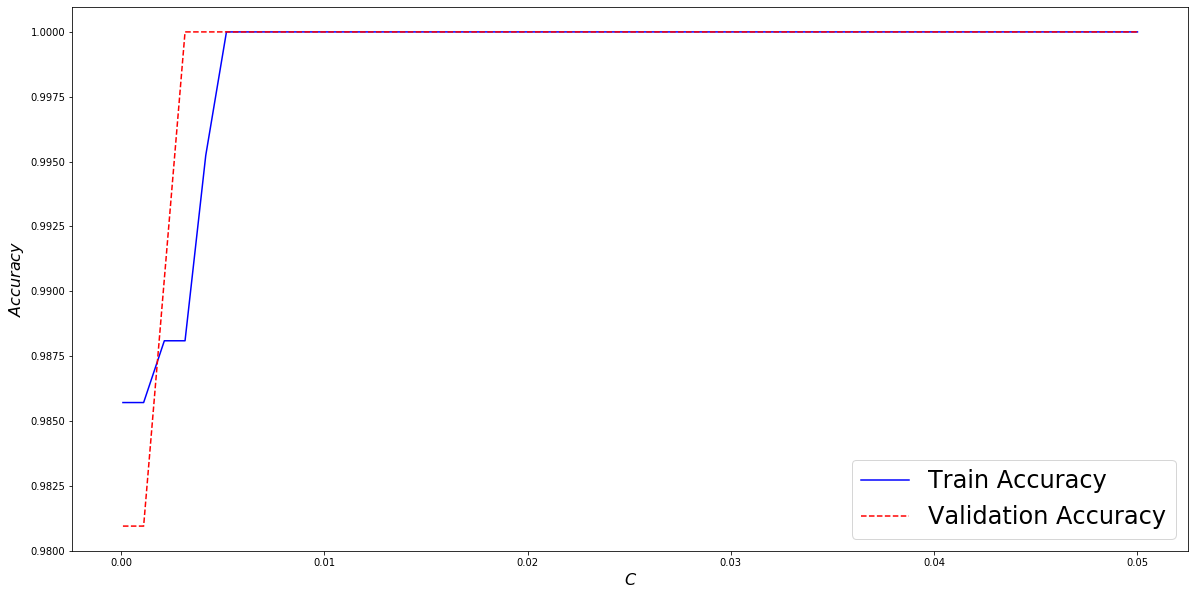

In [15]:
plt.figure(figsize=(20,10))
plt.plot(C, df2.groupby(['C'])['Train Accuracy'].mean(), 'b')
plt.plot(C, df2.groupby(['C'])['Validation Accuracy'].mean(), '--r')
plt.legend(("Train Accuracy", "Validation Accuracy"),fontsize=24)
plt.ylabel('$Accuracy$',weight='bold',fontsize=16)
plt.xlabel('$C$',weight='bold',fontsize=16)

#### We chose C, where the validation and train started to become 1. 
#### It seems C=0.005 is the optimum C for the logistic regression. However, values less than C in the interval where the test accuracy started to become greater than train (both have high accuracy) can also be considered the optimum C.

### Lets see the prediction for the test dataset by C=0.005

In [16]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X)
# logisitc regression fit by C = 0.005
clf = LogisticRegression(penalty='l2', C=0.005, solver='liblinear')
clf.fit(X_train_std, y)
# test accuracy
clf.score(X_test_std, y_test)

1.0